# Intent Classification Notebook

## Import Libraries

In [1]:
import pickle
import logging
import pandas as pd
import numpy as np
#from numpy import random
#import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from datetime import datetime

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewcarver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Data

In [3]:
intent_df = pd.read_csv('augmented_intents.csv', encoding='utf-8-sig')

In [4]:
# remove null values
intent_df = intent_df[pd.notnull(intent_df['intent'])]

## Explore Data

In [5]:
intent_df.intent.unique()

array(['greeting', 'drink_opinion.q', 'what_job.q', 'job_opinions.q',
       'what_goals.q', 'encouragement.s', 'hru.q', 'hobbies.q',
       'identity.q', 'where_from.q', 'well_wish.s', 'weather.q',
       'sports.q', 'movies.q', 'music.q', 'family.q', 'travel.q'],
      dtype=object)

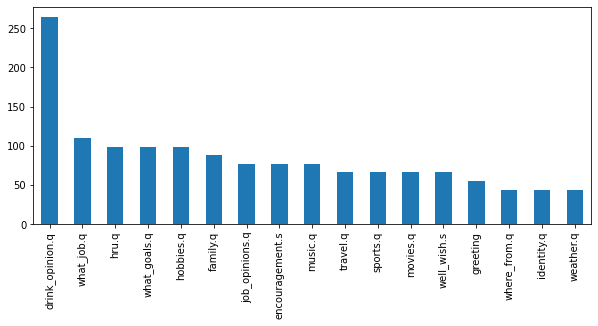

In [6]:
my_tags = ['greeting', 'drink_opinion.q', 'what_job.q', 'job_opinions.q',
       'what_goals.q', 'encouragement.s', 'hru.q', 'hobbies.q',
       'identity.q', 'where_from.q', 'well_wish.s', 'weather.q',
       'sports.q', 'movies.q', 'music.q', 'family.q', 'travel.q']
plt.figure(figsize=(10,4))
intent_df.intent.value_counts().plot(kind='bar');

In [7]:
print(intent_df.head(10))
print(intent_df['text'].apply(lambda x: len(x.split(' '))).sum())

                              text           intent
0                            hello         greeting
1                               hi         greeting
2                            howdy         greeting
3                        greetings         greeting
4                          welcome         greeting
5       how do you like the drink?  drink_opinion.q
6      how do you like your drink?  drink_opinion.q
7  how do you think of your drink?  drink_opinion.q
8   how do you think of the drink?  drink_opinion.q
9           do you like the drink?  drink_opinion.q
8482


In [8]:
def print_plot(index):
    example = intent_df[intent_df.index == index][['text', 'intent']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Intent:', example[1])
print_plot(40)

are you happy at your job?
Intent: job_opinions.q


## Preprocess

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

In [10]:
intent_df['text'] = intent_df['text'].apply(clean_text)

/opt/anaconda3/envs/botenv/lib/python3.8/site-packages/bs4/__init__.py:329: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


## Train Test Split

In [12]:
X = intent_df.text
y = intent_df.intent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

## Model

### Logistic Regression

In [13]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
#logreg.fit(X_train, y_train)
intent_model = logreg.fit(X_train, y_train)

%time

y_pred = intent_model.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred,target_names=my_tags))
print(classification_report(y_test, y_pred))

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 5.01 µs
accuracy 0.9342560553633218
                 precision    recall  f1-score   support

drink_opinion.q       0.98      0.98      0.98        48
encouragement.s       1.00      1.00      1.00        11
       family.q       1.00      0.90      0.95        20
       greeting       0.83      1.00      0.91         5
      hobbies.q       0.85      0.89      0.87        19
          hru.q       1.00      0.96      0.98        26
     identity.q       1.00      0.90      0.95        10
 job_opinions.q       0.67      1.00      0.80        14
       movies.q       1.00      0.92      0.96        13
        music.q       1.00      0.89      0.94        19
       sports.q       1.00      0.90      0.95        21
       travel.q       0.91      0.83      0.87        12
      weather.q       0.88      0.88      0.88         8
    well_wish.s       1.00      1.00      1.00        10
   what_goals.q       0.95      0.90      0.92    

/opt/anaconda3/envs/botenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Predictions

In [14]:
def predict_intent(text):
    x = [text]
    pred_intent = intent_model.predict(x)[0]
    prob = np.max(np.round(intent_model.predict_proba(x), 8))
    
    return pred_intent, prob

In [37]:
sample_q = 'what do you do for work?'
predict_intent(sample_q)

('what_job.q', 0.99998691)

In [44]:
def top_intents(text):
    x = [text]
    probabilities = intent_model.predict_log_proba(x)[0]
    intents = intent_model.classes_
    log_intents = pd.DataFrame({'intent':intents, 'log_prob':probabilities})
    top_intents = log_intents.sort_values(by='log_prob', ascending=False)[:4]

    return top_intents

In [46]:
sample_q = 'hello'
top_intents(sample_q)

,intent,log_prob
3,greeting,-0.000037
1,encouragement.s,-11.632720
5,hru.q,-12.314992
2,family.q,-12.417486


## Save Model

In [9]:
obj = datetime.now()
timestampStr = obj.strftime("%d-%b-%Y(%H:%M:%S)")
timestampStr

'17-Aug-2020(08:59:40)'

In [40]:
today = str(datetime.date(datetime.now()))
print(type(today))

<class 'str'>


In [41]:
pickle.dump(intent_model, open('intent_classification_model' + today, 'wb'))